In [35]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 100)
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import datetime
import json
from shapely import wkt

In [2]:
#reading deeds
deeds = pd.read_csv("data/SR1A_deeds/deeds_00_21_classified.csv", low_memory=False)

In [3]:
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,inv,occ,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup
0,0,714,"CAMPOS, FATIMA J",428 WASHINGTON AVE,"CLIFFSIDE PARK, NJ 00000","RYBRM HOLDINGS LLC,",198 CENTRAL AVE,"EAST ORANGE, NJ 00000",269 LAKE ST,540.0,43.0,NaN,2,21300,121100,99800,6/30/20,6/15/20,20200,60066,200000.0,26.0,1603.0,0.0,5696854.0,1902.0,NaN,NaN,06/15/20,2020-06-15,2020.0,Newark,NJ,NaN,5696854.0,40.760210,-74.179184,POINT (580992.187359745 702002.124279135),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0
1,1,714,"92 TUXEDO LLC,",13 MUNICIPAL PLZ #629,"BLOOMFIELD, NJ 00000","AGOSTO, STEPHEN F & WIGGIN, MATTHEW",92-94 TUXEDO PKWY,"NEWARK, NJ 00000",92-94 TUXEDO PKWY,4266.0,32.0,NaN,2,29400,138100,108700,6/30/20,5/18/20,20200,60247,285000.0,7.0,1582.0,0.0,5696855.0,1929.0,NaN,NaN,05/18/20,2020-05-18,2020.0,Newark,NJ,NaN,5696855.0,40.737785,-74.243770,POINT (563125.4362055603 693773.8672076497),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1
2,2,714,"PAULINO, JOSE M & TOMMY E",940 MADISON AVE,"PATERSON, NJ 00000","LIZARDO-SEQUENCIA, JAIME",490-492 SUMMER AVE,"NEWARK, NJ 00000",490-492 SUMMER AVE,625.0,41.0,NaN,2,35200,199100,163900,6/29/20,6/18/20,20200,59815,400000.0,7.0,2942.0,0.0,5696851.0,1908.0,NaN,NaN,06/18/20,2020-06-18,2020.0,Newark,NJ,NaN,5696851.0,40.768337,-74.166880,POINT (584389.2136115041 704975.4918734678),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1
3,3,714,CARRINGTON MORTGAGE SERVICES LLC,1600 S DOUGLASS RD #130A,"ANAHEIM, CA 00000",684 S 20TH STREET LLC,684 S 20TH ST,"NEWARK, NJ 00000",684 S 20TH ST,355.0,40.0,NaN,2,31300,155200,123900,6/29/20,6/16/20,20200,59718,142000.0,13.0,2044.0,0.0,5696849.0,1915.0,NaN,NaN,06/16/20,2020-06-16,2020.0,Newark,NJ,NaN,5696849.0,40.736100,-74.212040,POINT (571919.7568863531 693187.3110322659),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0
4,4,714,"KARTZMAN, STEVEN P",101 GIBRALTAR DR #2F,"MORRIS PLAINS, NJ 00000","TONKA HOLDINGS 2 LLC,",303 S 19TH ST,"NEWARK, NJ 00000",303 S 19TH ST,1794.0,8.0,NaN,2,21300,101300,80000,6/29/20,6/10/20,20200,59491,175000.0,13.0,1786.0,0.0,5696846.0,1897.0,NaN,NaN,06/10/20,2020-06-10,2020.0,Newark,NJ,NaN,5696846.0,40.746513,-74.206904,POINT (573330.3148576431 696985.4117777911),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0


In [4]:
#ranking to find most recent deed change (labeled as 1)
deeds['deed_date_dt_x'] = pd.to_datetime(deeds['deed_date_dt_x'])
deeds['Rank'] = deeds.groupby('Property Location_x')['deed_date_dt_x'].rank(ascending=False)

In [5]:
#sorting based on street address and receipt date
deeds = deeds.sort_values(by=['Property Location_x','deed_date_dt_x'])

In [7]:
#finding the owernship period of a deed
deeds['own_period'] = deeds.groupby('Property Location_x')['deed_date_dt_x'].diff() / np.timedelta64(1, 'D')
deeds['own_period'] = deeds['own_period'].fillna(999)

In [8]:
#classifying as investor rental, investor flip, or non investor
deeds['classification'] = np.where((deeds.investor_all == 1) & 
                                              (deeds.Rank == 1.0) & 
                                              (deeds.own_period >= 575) &
                                              (deeds.inv == 1), 'institutional investor rental', 
                                              np.where((deeds.investor_all == 1) & 
                                                       (deeds.Rank == 1.0) & 
                                                       (deeds.own_period >= 575) &
                                                       (deeds.inv == 0), 'non institutional investor rental',
                                                       np.where((deeds.investor_all == 1) & 
                                                                (deeds.inv==1) &
                                                                (deeds.own_period < 575), 'institutional investor flip', 
                                                                np.where((deeds.investor_all == 1) &
                                                                         (deeds.own_period < 575) &
                                                                         (deeds.inv == 0),'non institutional investor flip', 'non investor'))))
deeds['classification'] = deeds['classification'].fillna('non investor')

## Exploring Differences Over Time

In [11]:
investor_single_family_rentals = deeds[(deeds['classification'] == 'institutional investor rental')
                                                |(deeds['classification'] == 'non institutional investor rental')]
investor_single_family_rentals_00_18 = investor_single_family_rentals[investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]
investor_flips = deeds[(deeds['classification'] == 'institutional investor flip')
                                                |(deeds['classification'] == 'non institutional investor flip')]
investor_flips_00_18 = investor_flips[investor_flips['deed_date_dt_x'].dt.year <= 2018]
owner_occupants = deeds[deeds['classification'] == 'non investor']
owner_occupants_00_18 = owner_occupants[owner_occupants['deed_date_dt_x'].dt.year <= 2018]

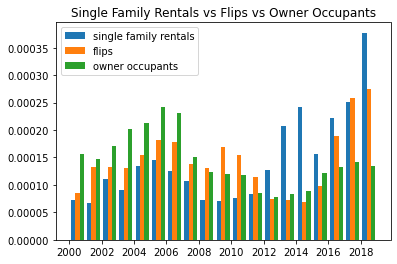

In [12]:
#plotting transactions by density
plt.title(label="Single Family Rentals vs Flips vs Owner Occupants")
plt.hist([investor_single_family_rentals_00_18['deed_date_dt_x'],investor_flips_00_18['deed_date_dt_x'],owner_occupants_00_18['deed_date_dt_x']],stacked=False, density=True, bins=19)
plt.legend(['single family rentals', 'flips', 'owner occupants'])

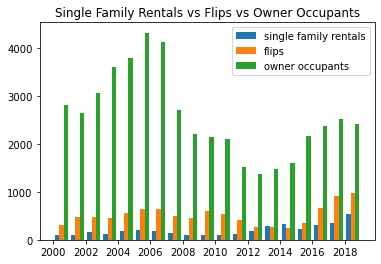

In [16]:
#plotting transactions by total value
plt.title(label="Single Family Rentals vs Flips vs Owner Occupants")
plt.hist([investor_single_family_rentals_00_18['deed_date_dt_x'],investor_flips_00_18['deed_date_dt_x'],owner_occupants_00_18['deed_date_dt_x']],stacked=False, density=False, bins=19)
plt.legend(['single family rentals', 'flips', 'owner occupants'])

In [13]:
institutional_investor_single_family_rentals = deeds[(deeds['classification'] == 'institutional investor rental')]
non_institutional_investor_single_family_rentals = deeds[(deeds['classification'] == 'non institutional investor rental')]

institutional_investor_single_family_rentals_00_18 = institutional_investor_single_family_rentals[institutional_investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]
non_institutional_investor_single_family_rentals_00_18 = non_institutional_investor_single_family_rentals[non_institutional_investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]

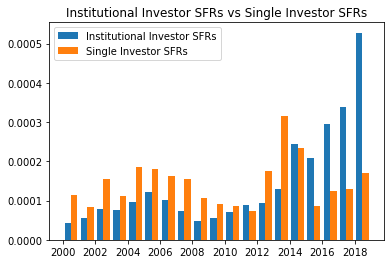

In [14]:
#investor breakdown by density
plt.title(label="Institutional Investor SFRs vs Single Investor SFRs")
plt.hist([institutional_investor_single_family_rentals_00_18['deed_date_dt_x'],non_institutional_investor_single_family_rentals_00_18['deed_date_dt_x']], stacked=False,density=True, bins=19)
plt.legend(['Institutional Investor SFRs', 'Single Investor SFRs'])

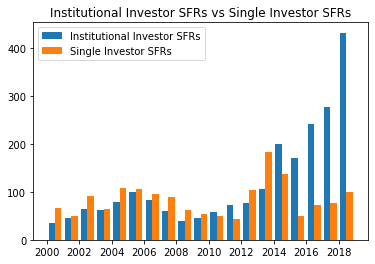

In [15]:
investor breakdown by total
plt.title(label="Institutional Investor SFRs vs Single Investor SFRs")
plt.hist([institutional_investor_single_family_rentals_00_18['deed_date_dt_x'],non_institutional_investor_single_family_rentals_00_18['deed_date_dt_x']], stacked=False,density=False, bins=19)
plt.legend(['Institutional Investor SFRs', 'Single Investor SFRs'])

In [29]:
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,inv,occ,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank,own_period,classification
39122,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,NaN,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,NaN,NaN,08/31/06,2006-08-31,2006.0,Newark,NJ,NaN,9111930.0,40.741497,-74.220240,POINT (569641.2266989056 695146.0638159891),False,0,1,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13,13.0,1.0,1.0,0,1.0,999.0,non institutional investor rental
46429,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,NaN,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,NaN,NaN,06/15/05,2005-06-15,2005.0,Newark,NJ,NaN,8604346.0,40.760153,-74.190428,POINT (577877.565242357 701970.0137778884),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1,1.0,999.0,non investor
57744,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,NaN,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,NaN,NaN,01/03/02,2002-01-03,2002.0,Newark,NJ,NaN,7053068.0,40.748870,-74.169055,POINT (583813.4924992458 697881.2696454047),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1,1.0,999.0,non investor
8037,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119549.0,40.779507,-74.171120,POINT (583199.6019454151 709040.2792985266),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0,1.5,999.0,non investor
8038,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119550.0,40.779507,-74.171120,POINT (583199.6019454151 709040.2792985266),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0,1.5,0.0,institutional investor flip


In [36]:
deeds['geometry'] = deeds['geometry'].apply(wkt.loads)

In [37]:
deeds_classified = gpd.GeoDataFrame(deeds, geometry = deeds['geometry'], crs = 'epsg:3424')

In [39]:
# saving final list of grantees
deeds_classified.to_file("data/SR1A_deeds/deeds_investors_rentals_flips.geojson", driver = "GeoJSON")

## Reimport geojson of classified deeds

In [69]:
#read in classified deeds file
deeds_classified = gpd.read_file("data/SR1A_deeds/deeds_investors_rentals_flips.geojson")


In [70]:
deeds_classified['count_field'] = 1
deeds_classified['year'] = deeds_classified['year'].astype(str).replace('\.0', '', regex=True)

In [71]:
deeds_classified['institutional_investor_rental'] = np.where(deeds_classified['classification'].str.contains('institutional investor rental', regex=True),1, 0)
deeds_classified['non_institutional_investor_rental'] = np.where(deeds_classified['classification'].str.contains('non institutional investor rental', regex=True),1, 0)
deeds_classified['institutional_investor_flip'] = np.where(deeds_classified['classification'].str.contains('institutional investor flip', regex=True),1, 0)
deeds_classified['non_institutional_investor_flip'] = np.where(deeds_classified['classification'].str.contains('non institutional investor flip', regex=True),1, 0)
deeds_classified['non_investor'] = np.where(deeds_classified['classification'].str.contains('non investor', regex=True),1, 0)

In [72]:
deeds_classified.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,grantee_y,inv,occ,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank,own_period,classification,geometry,count_field,institutional_investor_rental,non_institutional_investor_rental,institutional_investor_flip,non_institutional_investor_flip,non_investor
0,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,None,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,None,None,08/31/06,2006-08-31T00:00:00,2006,Newark,NJ,None,9111930.0,40.741497,-74.220240,False,0,1,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13,13.0,1.0,1.0,0,1.0,999.0,non institutional investor rental,POINT (569641.227 695146.064),1,1,1,0,0,0
1,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,None,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,None,None,06/15/05,2005-06-15T00:00:00,2005,Newark,NJ,None,8604346.0,40.760153,-74.190428,False,0,1,None,None,None,None,999,NaN,NaN,0.0,1,1.0,999.0,non investor,POINT (577877.565 701970.014),1,0,0,0,0,1
2,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,None,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,None,None,01/03/02,2002-01-03T00:00:00,2002,Newark,NJ,None,7053068.0,40.748870,-74.169055,False,0,1,None,None,None,None,999,NaN,NaN,0.0,1,1.0,999.0,non investor,POINT (583813.492 697881.270),1,0,0,0,0,1
3,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,None,None,03/23/18,2018-03-23T00:00:00,2018,Newark,NJ,None,5119549.0,40.779507,-74.171120,True,1,0,None,None,None,None,999,NaN,NaN,1.0,0,1.5,999.0,non investor,POINT (583199.602 709040.279),1,0,0,0,0,1
4,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,None,None,03/23/18,2018-03-23T00:00:00,2018,Newark,NJ,None,5119550.0,40.779507,-74.171120,True,1,0,None,None,None,None,999,NaN,NaN,1.0,0,1.5,0.0,institutional investor flip,POINT (583199.602 709040.279),1,0,0,1,0,0


In [93]:
res_properties = gpd.read_file("data/newark_parcels/Lot_Area.shp")

In [94]:
res_properties = res_properties.to_crs('epsg:3424')

In [95]:
res_properties_counts = res_properties[['ID', 'geometry']]

In [96]:
res_properties_counts = res_properties_counts.rename(columns = {'ID':'res_parcel_num'})

In [52]:
tracts = gpd.read_file('data/newark_tracts/newarktractpolygon.geojson')

In [46]:
wards = gpd.read_file('data/newark_wards/Wards_2012.shp')

In [53]:
#reprojecting tracts
tracts = tracts.to_crs('epsg:3424')

In [48]:
#reprojecting wards
wards = wards.to_crs('epsg:3424')

## Spatial Join between Deeds and Wards

In [73]:
deeds_tracts = gpd.sjoin(tracts, deeds_classified, how='left', op='intersects').reset_index()

In [74]:
#getting counts of purchases by type for year block for each year

grouped_deeds = deeds_tracts.groupby(['GEOID', 'year']).agg({'institutional_investor_rental':'sum',
                                                        'non_institutional_investor_rental':'sum',
                                                        'institutional_investor_flip':'sum', 'non_institutional_investor_flip':'sum',
                                                        'non_investor':'sum','count_field':'count'}).unstack()

In [75]:
# unstacking the grouped columns
new_cols = [''.join(t) for t in grouped_deeds.columns]
grouped_deeds.columns = new_cols

In [76]:
grouped_deeds.head()

,institutional_investor_rental2000,institutional_investor_rental2001,institutional_investor_rental2002,institutional_investor_rental2003,institutional_investor_rental2004,institutional_investor_rental2005,institutional_investor_rental2006,institutional_investor_rental2007,institutional_investor_rental2008,institutional_investor_rental2009,institutional_investor_rental2010,institutional_investor_rental2011,institutional_investor_rental2012,institutional_investor_rental2013,institutional_investor_rental2014,institutional_investor_rental2015,institutional_investor_rental2016,institutional_investor_rental2017,institutional_investor_rental2018,institutional_investor_rental2019,institutional_investor_rental2020,non_institutional_investor_rental2000,non_institutional_investor_rental2001,non_institutional_investor_rental2002,non_institutional_investor_rental2003,non_institutional_investor_rental2004,non_institutional_investor_rental2005,non_institutional_investor_rental2006,non_institutional_investor_rental2007,non_institutional_investor_rental2008,non_institutional_investor_rental2009,non_institutional_investor_rental2010,non_institutional_investor_rental2011,non_institutional_investor_rental2012,non_institutional_investor_rental2013,non_institutional_investor_rental2014,non_institutional_investor_rental2015,non_institutional_investor_rental2016,non_institutional_investor_rental2017,non_institutional_investor_rental2018,non_institutional_investor_rental2019,non_institutional_investor_rental2020,institutional_investor_flip2000,institutional_investor_flip2001,institutional_investor_flip2002,institutional_investor_flip2003,institutional_investor_flip2004,institutional_investor_flip2005,institutional_investor_flip2006,institutional_investor_flip2007,...,non_institutional_investor_flip2013,non_institutional_investor_flip2014,non_institutional_investor_flip2015,non_institutional_investor_flip2016,non_institutional_investor_flip2017,non_institutional_investor_flip2018,non_institutional_investor_flip2019,non_institutional_investor_flip2020,non_investor2000,non_investor2001,non_investor2002,non_investor2003,non_investor2004,non_investor2005,non_investor2006,non_investor2007,non_investor2008,non_investor2009,non_investor2010,non_investor2011,non_investor2012,non_investor2013,non_investor2014,non_investor2015,non_investor2016,non_investor2017,non_investor2018,non_investor2019,non_investor2020,count_field2000,count_field2001,count_field2002,count_field2003,count_field2004,count_field2005,count_field2006,count_field2007,count_field2008,count_field2009,count_field2010,count_field2011,count_field2012,count_field2013,count_field2014,count_field2015,count_field2016,count_field2017,count_field2018,count_field2019,count_field2020
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34013000100,1.0,1.0,3.0,4.0,2.0,0.0,0.0,2.0,2.0,4.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,14.0,4.0,3.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,5.0,3.0,0.0,2.0,5.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,57.0,60.0,70.0,100.0,75.0,90.0,80.0,51.0,31.0,34.0,35.0,27.0,28.0,27.0,29.0,50.0,53.0,56.0,61.0,42.0,11.0,60.0,66.0,76.0,104.0,79.0,95.0,83.0,56.0,40.0,38.0,36.0,29.0,29.0,29.0,31.0,51.0,54.0,63.0,100.0,52.0,14.0
34013000200,1.0,4.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0,4.0,0.0,0.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0,5.0,1.0,4.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,20.0,21.0,31.0,29.0,24.0,32.0,40.0,19.0,15.0,19.0,11.0,10.0,9.0,7.0,16.0,11.0,16.0,14.0,20.0,13.0,1.0,23.0,27.0,34.0,35.0,26.0,37.0,43.0,21.0,16.0,20.0,16.0,15.0,14.0,10.0,20.0,12.0,18.0,21.0,26.0,19.0,3.0
34013000300,3.0,0.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,0.0,1.0,5.0,0.0,6.0,0.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,8.0,3.0,6.0,3.0,2.0,...,3.0,1.0

In [77]:
tract_geometry = tracts[['GEOID', 'geometry']]

In [78]:
#merging groupd blocks with geometry field
grouped_deeds = tract_geometry.merge(grouped_deeds, how='left', left_on="GEOID", right_on="GEOID")

#converting to a geodataframe
grouped_deeds = gpd.GeoDataFrame(grouped_deeds, geometry = grouped_deeds['geometry'])


In [97]:
# joining residential parcels from Lot Area to tracts to have count of parcels
res_tracts = gpd.sjoin(tracts, res_properties_counts, how='left', op='intersects').reset_index()

In [98]:
res_tracts.head()

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,index_right,res_parcel_num
0,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",26538,30423
1,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",26034,30464
2,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",25506,30484
3,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",25500,30471
4,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",25446,30450


In [99]:
res_count = res_tracts.groupby(['GEOID']).agg({'res_parcel_num':'count'}).reset_index()

In [100]:
grouped_deeds = grouped_deeds.merge(res_count, how="left", left_on='GEOID', right_on='GEOID')

## Calculating percent by classification purchases per tract per year

In [101]:
# percent of purchases by block that are institutional investor purchases for rentals
#2000
grouped_deeds['per_inst_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_inst_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_inst_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_inst_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_inst_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_inst_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_inst_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_inst_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_inst_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_inst_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_inst_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_inst_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_inst_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_inst_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_inst_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_inst_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_inst_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_inst_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_inst_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

### non institutional investor rentals

In [102]:
# percent of purchases by block that are non-institutional investor purchases for rentals
#2000
grouped_deeds['per_non_inst_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inst_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inst_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inst_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inst_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inst_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inst_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inst_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inst_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inst_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inst_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inst_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inst_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inst_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inst_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inst_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inst_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inst_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inst_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

### institutional investor flip

In [103]:
# percent of purchases by block that are institutional investor purchases for flip
#2000
grouped_deeds['per_inst_inv_flip_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_inst_inv_flip_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_inst_inv_flip_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_inst_inv_flip_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_inst_inv_flip_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_inst_inv_flip_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_inst_inv_flip_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_inst_inv_flip_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_inst_inv_flip_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_inst_inv_flip_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_inst_inv_flip_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_inst_inv_flip_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_inst_inv_flip_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_inst_inv_flip_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_inst_inv_flip_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_inst_inv_flip_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_inst_inv_flip_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_inst_inv_flip_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_inst_inv_flip_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

### non institutional investor flip

In [104]:
# percent of purchases by block that are non-institutional investor purchases for flip
#2000
grouped_deeds['per_non_inst_inv_flip_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inst_inv_flip_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inst_inv_flip_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inst_inv_flip_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inst_inv_flip_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inst_inv_flip_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inst_inv_flip_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inst_inv_flip_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inst_inv_flip_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inst_inv_flip_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inst_inv_flip_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inst_inv_flip_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inst_inv_flip_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inst_inv_flip_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inst_inv_flip_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inst_inv_flip_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inst_inv_flip_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inst_inv_flip_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inst_inv_flip_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

### percent non investor/owner occupied

In [105]:
# percent of purchases by block that are non-investor purchases for owner occupation
#2000
grouped_deeds['per_non_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_investor2018']/x['res_parcel_num'], axis=1)

In [ ]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var_d1018 = [i for i in grouped_deeds10_18_i.columns]
var_d0010 = [i for i in grouped_deeds00_10_i.columns]
var_f1018 = [i for i in grouped_foreclosures10_18_i.columns]
var_f0010 = [i for i in grouped_foreclosures00_10_i.columns]

var_d1018.remove('geometry')
var_d0010.remove('geometry')
var_f1018.remove('geometry')
var_f0010.remove('geometry')